In [1]:
import pyximport
import numpy as np
import menpo.io as mio
import tensorflow as tf
import losses

from evaluation import score
from pathlib import Path

slim = tf.contrib.slim
pyximport.install()

from fast_dtw import dtw, dtw_lc
from menpo.visualize import print_progress
cached_data_path = Path('mmi_smile.pkl')

## Load data

In [2]:
data, gnd = mio.import_pickle(cached_data_path)

## Network

In [3]:
source_images = tf.placeholder(tf.float32, shape=(None, 40, 40, 1))
target_images = tf.placeholder(tf.float32, shape=(None, 40, 40, 1))

def network(images):
    with slim.arg_scope([slim.conv2d, slim.fully_connected], normalizer_fn=slim.batch_norm, outputs_collections='output'):
        net = slim.conv2d(images, 32, 3) # 40x40
        net = slim.max_pool2d(net, 2) # 20x20
        net = slim.conv2d(net, 32, 3) 
        net = slim.max_pool2d(net, 2) # 10x10
        net = slim.flatten(net)
        net = slim.fully_connected(net, 10, activation_fn=None)
    return net

In [4]:
with tf.variable_scope('net', reuse=False):
    source_proj = network(source_images)
    
with tf.variable_scope('net', reuse=True):
    target_proj = network(target_images)

## Define losses

In [5]:
cost = losses.correlation_cost(source_proj, target_proj, 0, 0)

opt = tf.train.AdamOptimizer(.0005)
train_op = opt.minimize(cost)

In [6]:
sess = tf.Session()

In [7]:
sess.run(tf.initialize_all_variables())

In [8]:
from menpo.visualize import print_dynamic

In [9]:
def init_path(source, target):
    Vs = [source, target]

    P = np.zeros((max([x.shape[0] for x in Vs]), len(Vs)), int)

    for i in range(P.shape[1]):
        P[:, i] = np.linspace(0, Vs[i].shape[0] - 1, num=P.shape[0]).round()

    return P

In [10]:
current_paths = {}
current_scores = {}

### Training

In [11]:
# This are the samples used in the paper. 
subs = [0, 1, 5, 6, 12, 16, 18, 19, 24, 25]

In [12]:
num_videos = len(subs)
num_epochs = 5

for epoch in range(num_epochs):
    for idx, i in enumerate(subs):
        for j in subs:
            if j < i: continue

            if (i, j) not in current_paths:
                current_paths[(i, j)] = init_path(data[i], data[j])

            path = current_paths[(i, j)].T
            loss, _, fx, gx = sess.run((cost, train_op, source_proj, target_proj), feed_dict={
                        source_images: data[i].transpose(0, 2, 3, 1)[path[0]],
                        target_images: data[j].transpose(0, 2, 3, 1)[path[1]]
            })

            # Gets the unique observations.
            fx = fx[np.unique(path[0], return_index=True)[1]].astype(np.float)
            gx = gx[np.unique(path[1], return_index=True)[1]].astype(np.float)

            # Solves for the warping.
            path = dtw(fx, gx)
            
            valuation = score(gnd[i][path[:, 0]], gnd[j][path[:, 1]])
            current_scores[(i, j)] = valuation

            current_paths[(i, j)] = path
            mean_score = np.mean(list(current_scores.values()))

            print_dynamic("Loss: {:3f}, Score: {:.2f} {}/{} -- Epoch {}/{}".format(
                    loss[0], mean_score, idx, num_videos, epoch, num_epochs))

Loss: -339.498474, Score: 0.57 9/10 -- Epoch 4/5                                

In [13]:
# good ids: 0, 8, 18

In [84]:
video_id = 29

f = sess.run(tf.get_collection('output')[1], feed_dict={
    source_images: data[video_id].transpose(0, 2, 3, 1),
})

In [85]:
%matplotlib inline
from menpo.image import Image

In [86]:
def merge_images(*images, group=None):
    if len(images) == 1:
        images = images[0]
        
    image_widths = np.cumsum([0] + [im.shape[1] for im in images])

    merged_im = Image(np.concatenate([im.pixels for im in images], 2))
    return merged_im

In [87]:
list(Path('/vol/atlas/homes/gt108/db/MMI_smile/').glob('*frames'))[29]

PosixPath('/vol/atlas/homes/gt108/db/MMI_smile/S014-009_frames')

In [88]:
frames = mio.import_images(list(Path('/vol/atlas/homes/gt108/db/MMI_smile/').glob('*frames'))[video_id])
frames = sorted(frames, key=lambda a: int(a.path.stem.split('_')[1]))
images = [frames[i].crop_to_landmarks().resize((100, 100)) for i in np.linspace(0, len(data[video_id])-1, 7).round().astype(int)]

In [98]:
# images = [Image(data[video_id][i, 0]) for i in np.linspace(0, len(data[video_id])-1, 5).round()]
# features = [Image(f[i, ..., 23]).resize((40, 40)) for i in np.linspace(0, len(data[video_id])-1, 7).round()]
features = [Image(f[i].mean(-1)).resize((40, 40)) for i in np.linspace(0, len(data[video_id])-1, 7).round()]

/vol/atlas/homes/gt108/miniconda/envs/menpo/lib/python3.5/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


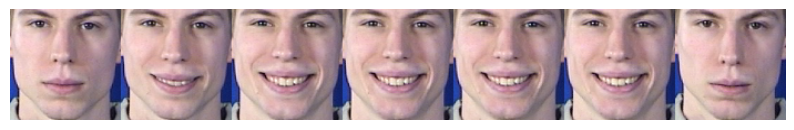

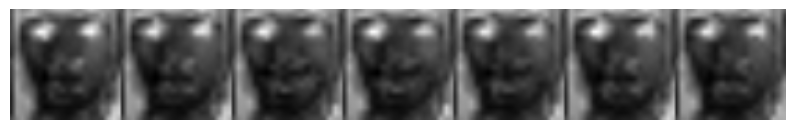

In [99]:
merge_images(*images).view()
merge_images(*features).view(new_figure=True)

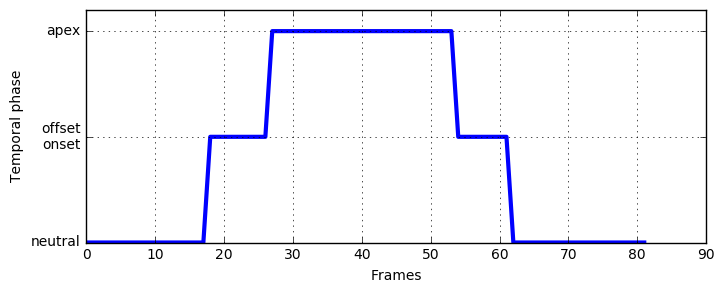

In [135]:
import matplotlib.pyplot as plt

def tt(x):
    x = x.copy()
    x[x==3] = 1
    return x

plt.figure(figsize=(8, 3))
plt.plot(tt(gnd[video_id]), linewidth=3)
plt.ylabel('Temporal phase')
plt.ylim([0, 2.2])
plt.grid()
plt.yticks(np.arange(3), np.array(['neutral', 'offset\nonset', 'apex']))
plt.xlabel('Frames')